In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json

import lightgbm as lgb
from sklearn.model_selection import GroupKFold

print("Lightgbm version:", lgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 281
Categorical features: 6


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 281
Categorical Columns: 6


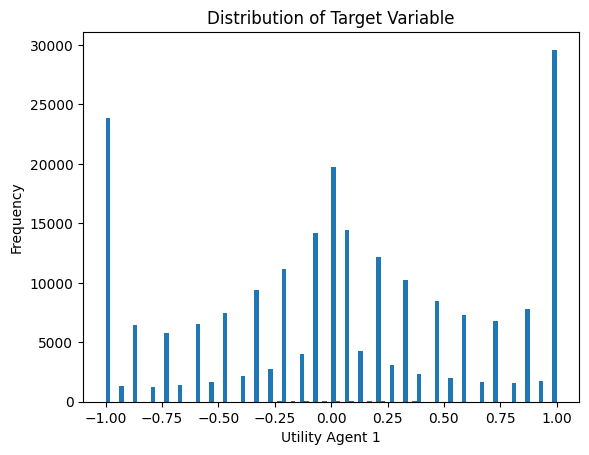

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model


Fold 1
[50]	valid_0's rmse: 0.463525
[100]	valid_0's rmse: 0.448863
[150]	valid_0's rmse: 0.440388
[200]	valid_0's rmse: 0.434219
[250]	valid_0's rmse: 0.431825
[300]	valid_0's rmse: 0.428687
[350]	valid_0's rmse: 0.426883
[400]	valid_0's rmse: 0.425883
[450]	valid_0's rmse: 0.424779
[500]	valid_0's rmse: 0.424088
[550]	valid_0's rmse: 0.423604
[600]	valid_0's rmse: 0.423087
[650]	valid_0's rmse: 0.422638
[700]	valid_0's rmse: 0.422347
[750]	valid_0's rmse: 0.421975
[800]	valid_0's rmse: 0.421479
[850]	valid_0's rmse: 0.421269
[900]	valid_0's rmse: 0.421316
[950]	valid_0's rmse: 0.421366
[1000]	valid_0's rmse: 0.42135
[1050]	valid_0's rmse: 0.421344
[1100]	valid_0's rmse: 0.421573
[1150]	valid_0's rmse: 0.421656
[1200]	valid_0's rmse: 0.421442
[1250]	valid_0's rmse: 0.421349
[1300]	valid_0's rmse: 0.421285
[1350]	valid_0's rmse: 0.421246
[1400]	valid_0's rmse: 0.421254
[1450]	valid_0's rmse: 0.421279
[1500]	valid_0's rmse: 0.421299
[1550]	valid_0's rmse: 0.421388
[1600]	valid_0's rmse:

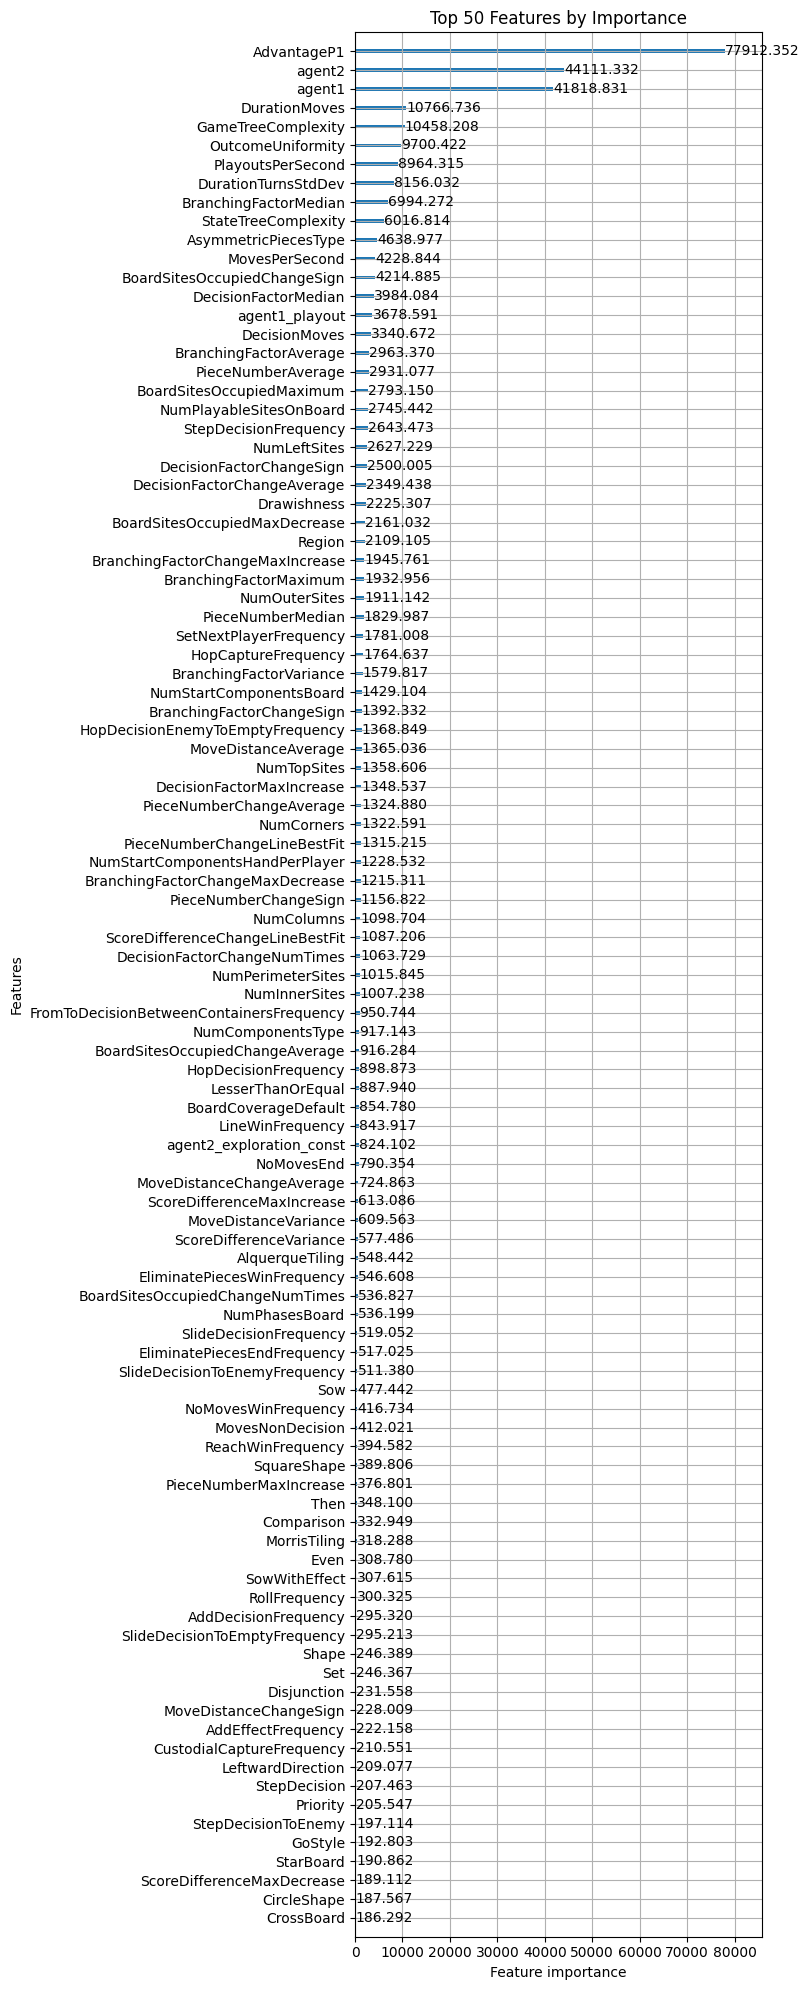

Fold 1 - RMSE: 0.4203707711710769
Fold 2
[50]	valid_0's rmse: 0.474625
[100]	valid_0's rmse: 0.458655
[150]	valid_0's rmse: 0.451048
[200]	valid_0's rmse: 0.447261
[250]	valid_0's rmse: 0.445612
[300]	valid_0's rmse: 0.443473
[350]	valid_0's rmse: 0.440873
[400]	valid_0's rmse: 0.439353
[450]	valid_0's rmse: 0.438521
[500]	valid_0's rmse: 0.437347
[550]	valid_0's rmse: 0.436679
[600]	valid_0's rmse: 0.435432
[650]	valid_0's rmse: 0.434944
[700]	valid_0's rmse: 0.434645
[750]	valid_0's rmse: 0.434642
[800]	valid_0's rmse: 0.434346
[850]	valid_0's rmse: 0.434474
[900]	valid_0's rmse: 0.434029
[950]	valid_0's rmse: 0.433754
[1000]	valid_0's rmse: 0.43373
[1050]	valid_0's rmse: 0.433525
[1100]	valid_0's rmse: 0.433574
[1150]	valid_0's rmse: 0.433384
[1200]	valid_0's rmse: 0.43337
[1250]	valid_0's rmse: 0.433321
[1300]	valid_0's rmse: 0.433185
[1350]	valid_0's rmse: 0.43305
[1400]	valid_0's rmse: 0.433059
[1450]	valid_0's rmse: 0.433014
[1500]	valid_0's rmse: 0.432936
[1550]	valid_0's rmse:

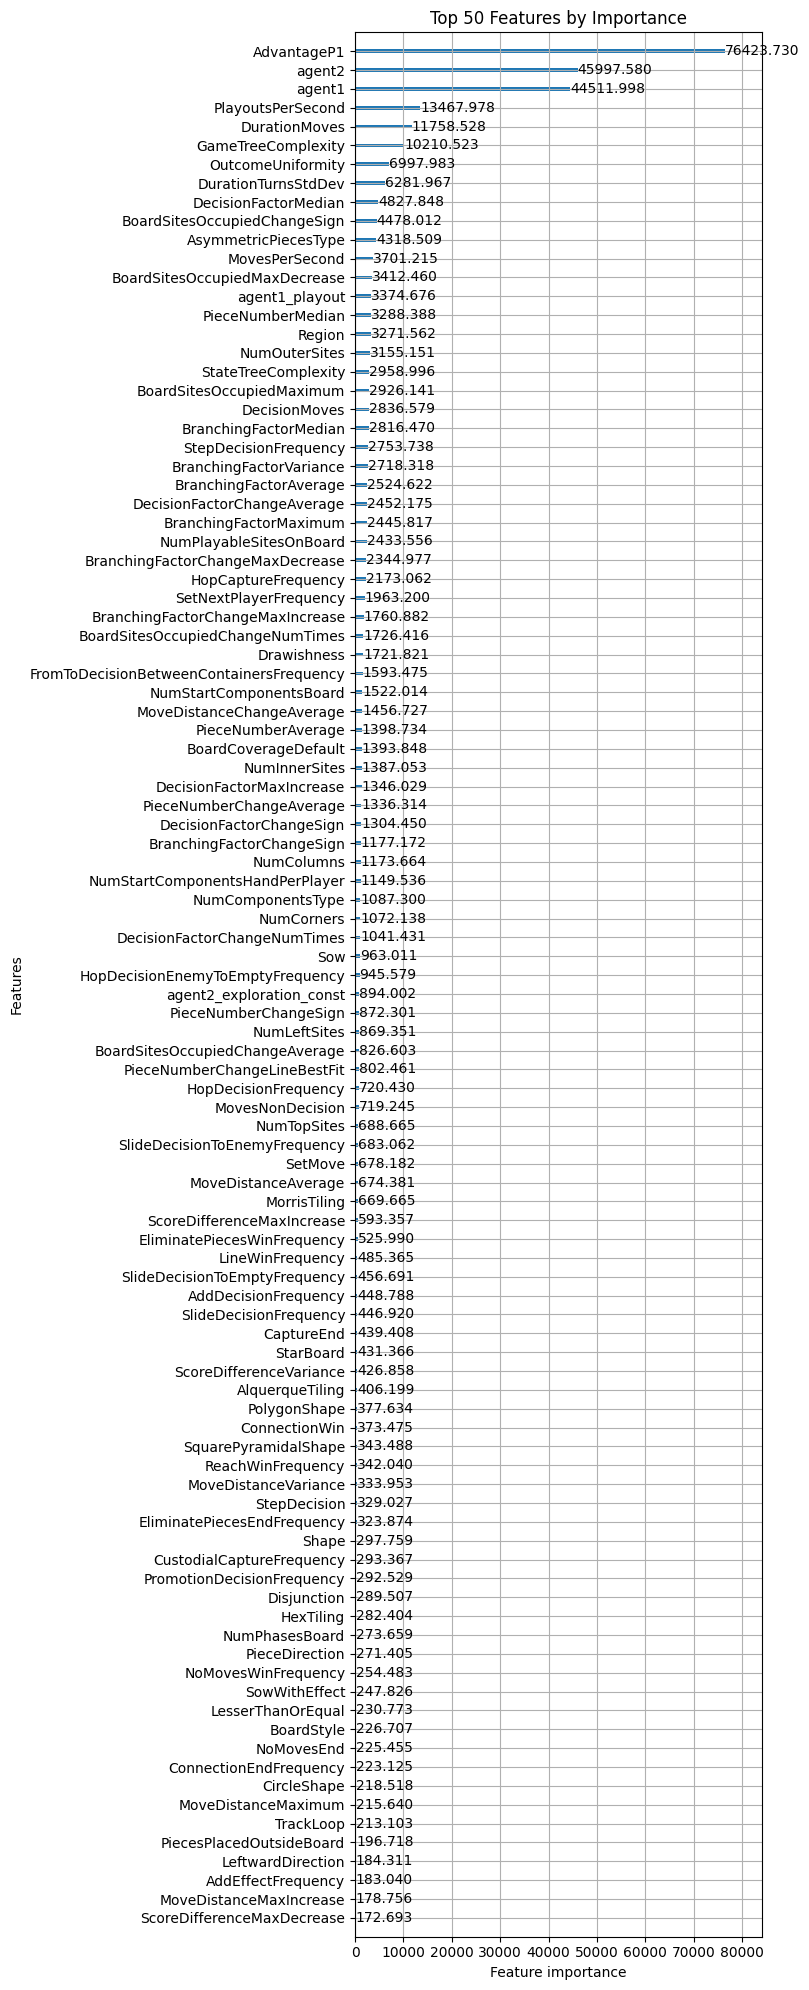

Fold 2 - RMSE: 0.43224830560396205
Fold 3
[50]	valid_0's rmse: 0.479795
[100]	valid_0's rmse: 0.465051
[150]	valid_0's rmse: 0.457436
[200]	valid_0's rmse: 0.454618
[250]	valid_0's rmse: 0.452207
[300]	valid_0's rmse: 0.450027
[350]	valid_0's rmse: 0.448526
[400]	valid_0's rmse: 0.447052
[450]	valid_0's rmse: 0.446175
[500]	valid_0's rmse: 0.445295
[550]	valid_0's rmse: 0.444686
[600]	valid_0's rmse: 0.444286
[650]	valid_0's rmse: 0.444234
[700]	valid_0's rmse: 0.443485
[750]	valid_0's rmse: 0.442916
[800]	valid_0's rmse: 0.442331
[850]	valid_0's rmse: 0.44211
[900]	valid_0's rmse: 0.441863
[950]	valid_0's rmse: 0.441431
[1000]	valid_0's rmse: 0.441119
[1050]	valid_0's rmse: 0.441012
[1100]	valid_0's rmse: 0.441008
[1150]	valid_0's rmse: 0.440724
[1200]	valid_0's rmse: 0.440697
[1250]	valid_0's rmse: 0.440573
[1300]	valid_0's rmse: 0.440705
[1350]	valid_0's rmse: 0.440478
[1400]	valid_0's rmse: 0.44033
[1450]	valid_0's rmse: 0.440194
[1500]	valid_0's rmse: 0.440065
[1550]	valid_0's rms

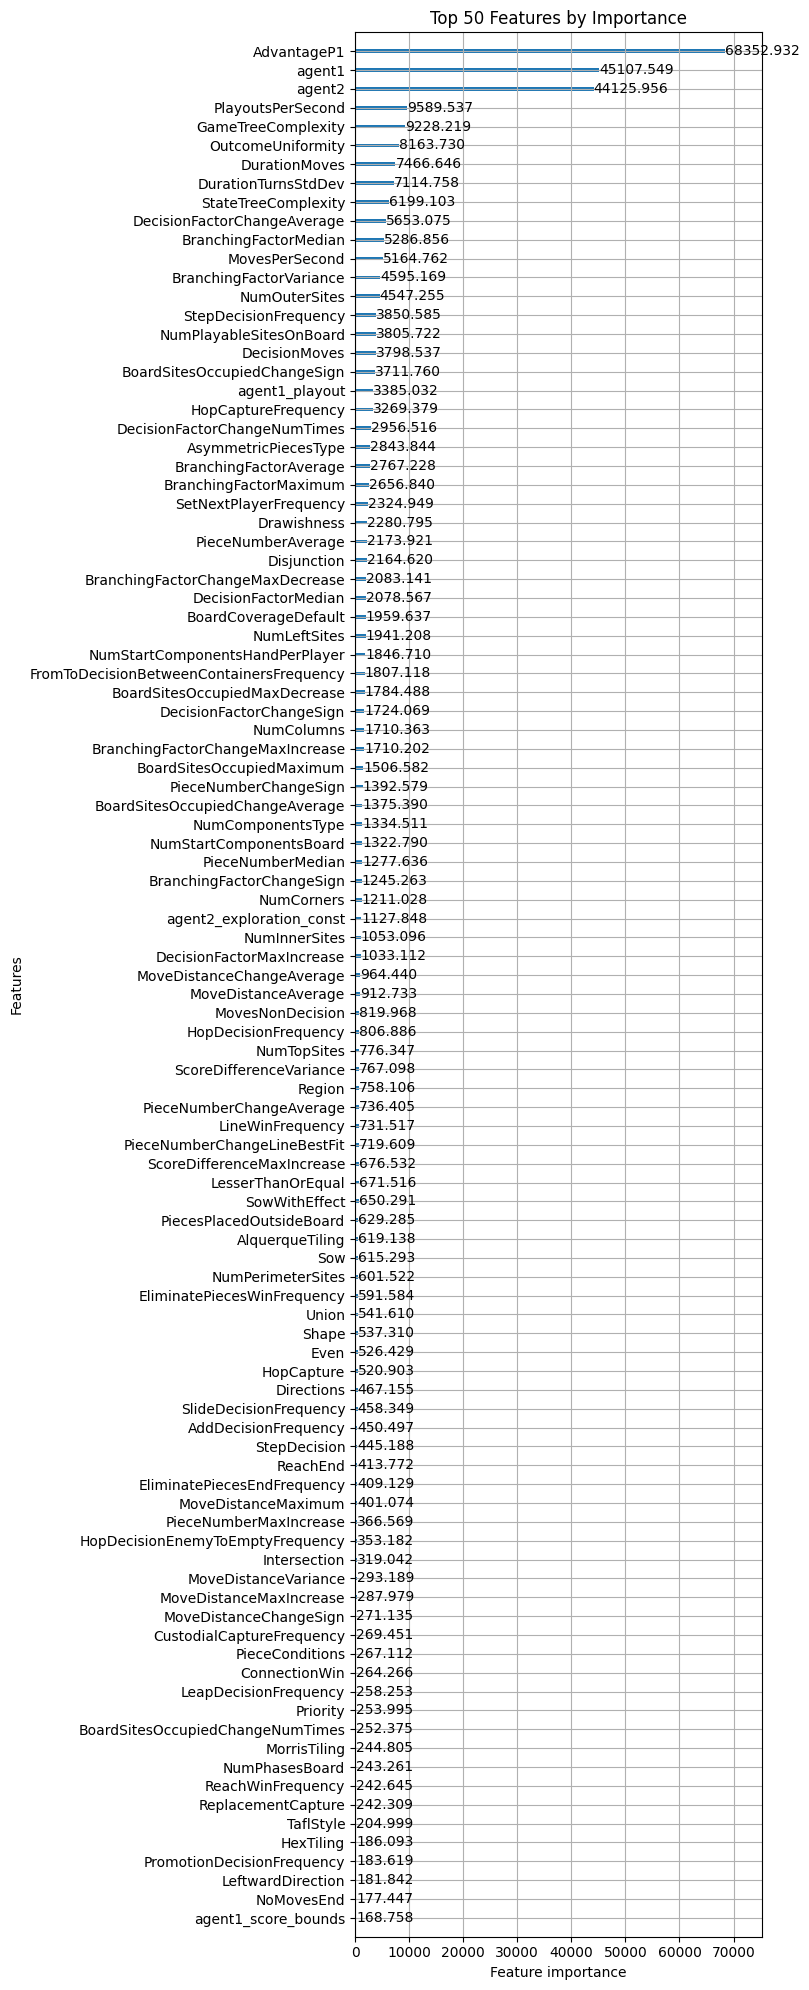

Fold 3 - RMSE: 0.43923864935783286
Fold 4
[50]	valid_0's rmse: 0.471398
[100]	valid_0's rmse: 0.456267
[150]	valid_0's rmse: 0.449111
[200]	valid_0's rmse: 0.445491
[250]	valid_0's rmse: 0.442362
[300]	valid_0's rmse: 0.43996
[350]	valid_0's rmse: 0.438477
[400]	valid_0's rmse: 0.437086
[450]	valid_0's rmse: 0.435768
[500]	valid_0's rmse: 0.435119
[550]	valid_0's rmse: 0.434402
[600]	valid_0's rmse: 0.434243
[650]	valid_0's rmse: 0.433887
[700]	valid_0's rmse: 0.433559
[750]	valid_0's rmse: 0.433387
[800]	valid_0's rmse: 0.433146
[850]	valid_0's rmse: 0.433014
[900]	valid_0's rmse: 0.432743
[950]	valid_0's rmse: 0.432552
[1000]	valid_0's rmse: 0.43228
[1050]	valid_0's rmse: 0.432139
[1100]	valid_0's rmse: 0.432015
[1150]	valid_0's rmse: 0.432019
[1200]	valid_0's rmse: 0.431762
[1250]	valid_0's rmse: 0.431574
[1300]	valid_0's rmse: 0.431411
[1350]	valid_0's rmse: 0.431218
[1400]	valid_0's rmse: 0.431024
[1450]	valid_0's rmse: 0.430983
[1500]	valid_0's rmse: 0.430879
[1550]	valid_0's rms

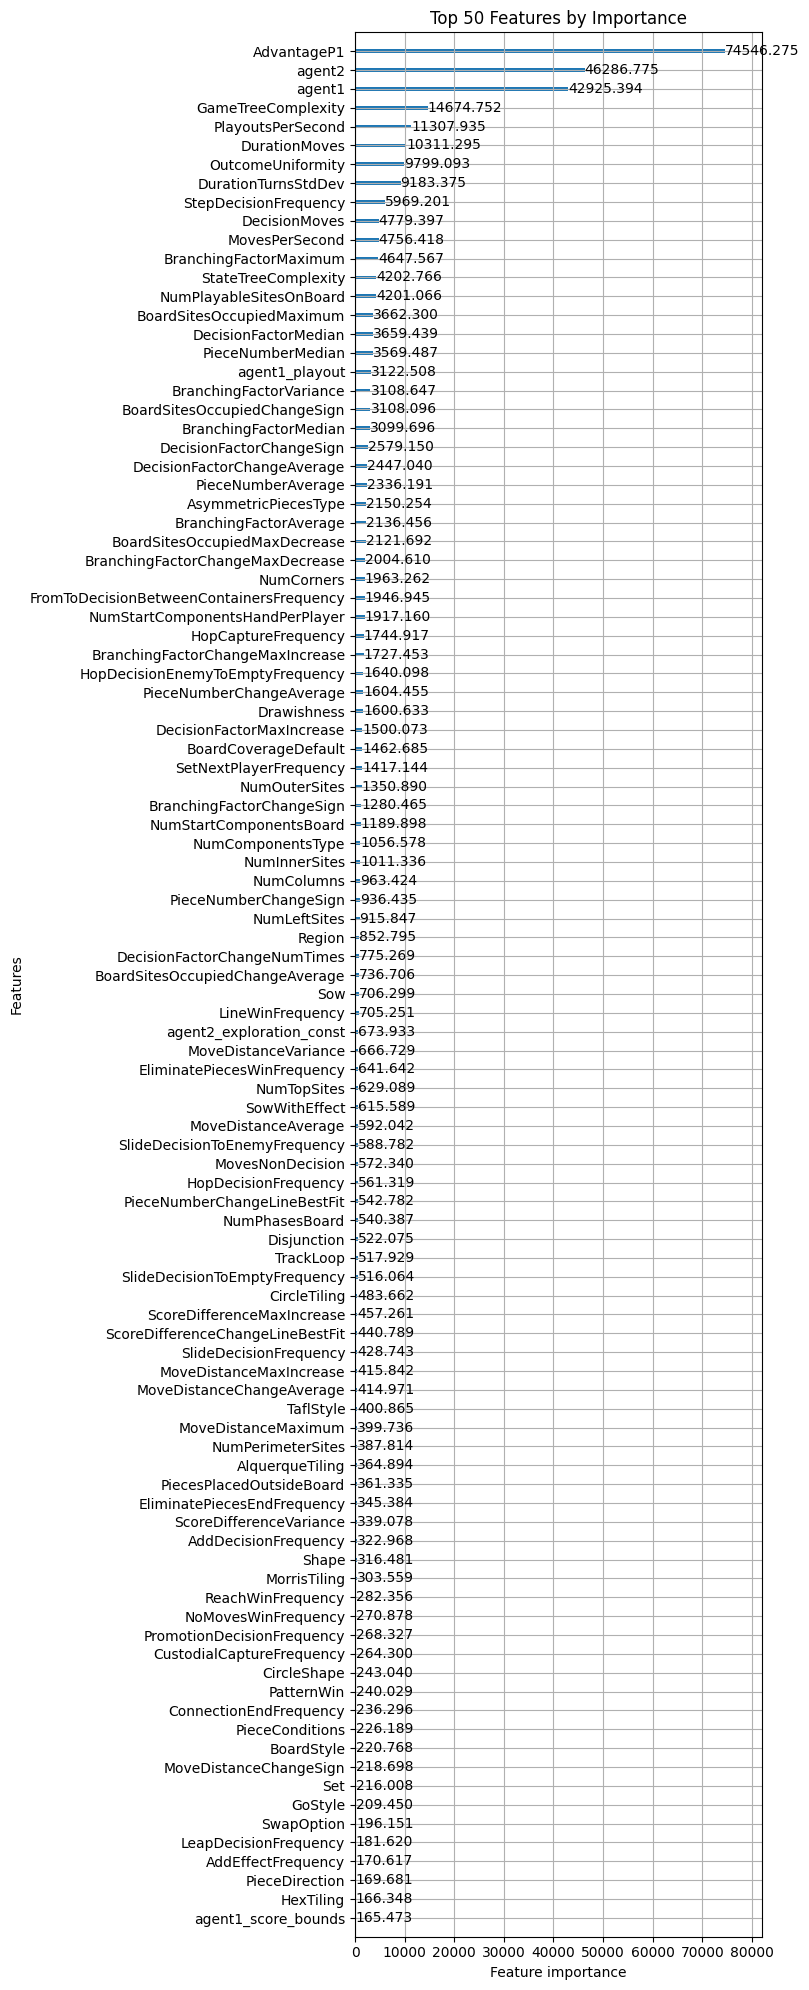

Fold 4 - RMSE: 0.4298461167754095
Fold 5
[50]	valid_0's rmse: 0.462626
[100]	valid_0's rmse: 0.444199
[150]	valid_0's rmse: 0.435203
[200]	valid_0's rmse: 0.430338
[250]	valid_0's rmse: 0.427915
[300]	valid_0's rmse: 0.425988
[350]	valid_0's rmse: 0.425164
[400]	valid_0's rmse: 0.423876
[450]	valid_0's rmse: 0.422975
[500]	valid_0's rmse: 0.421907
[550]	valid_0's rmse: 0.421175
[600]	valid_0's rmse: 0.420687
[650]	valid_0's rmse: 0.419809
[700]	valid_0's rmse: 0.419131
[750]	valid_0's rmse: 0.418928
[800]	valid_0's rmse: 0.41872
[850]	valid_0's rmse: 0.418428
[900]	valid_0's rmse: 0.418123
[950]	valid_0's rmse: 0.417827
[1000]	valid_0's rmse: 0.41766
[1050]	valid_0's rmse: 0.41753
[1100]	valid_0's rmse: 0.417485
[1150]	valid_0's rmse: 0.41734
[1200]	valid_0's rmse: 0.417327
[1250]	valid_0's rmse: 0.416992
[1300]	valid_0's rmse: 0.416887
[1350]	valid_0's rmse: 0.416783
[1400]	valid_0's rmse: 0.416517
[1450]	valid_0's rmse: 0.416476
[1500]	valid_0's rmse: 0.41647
[1550]	valid_0's rmse: 0

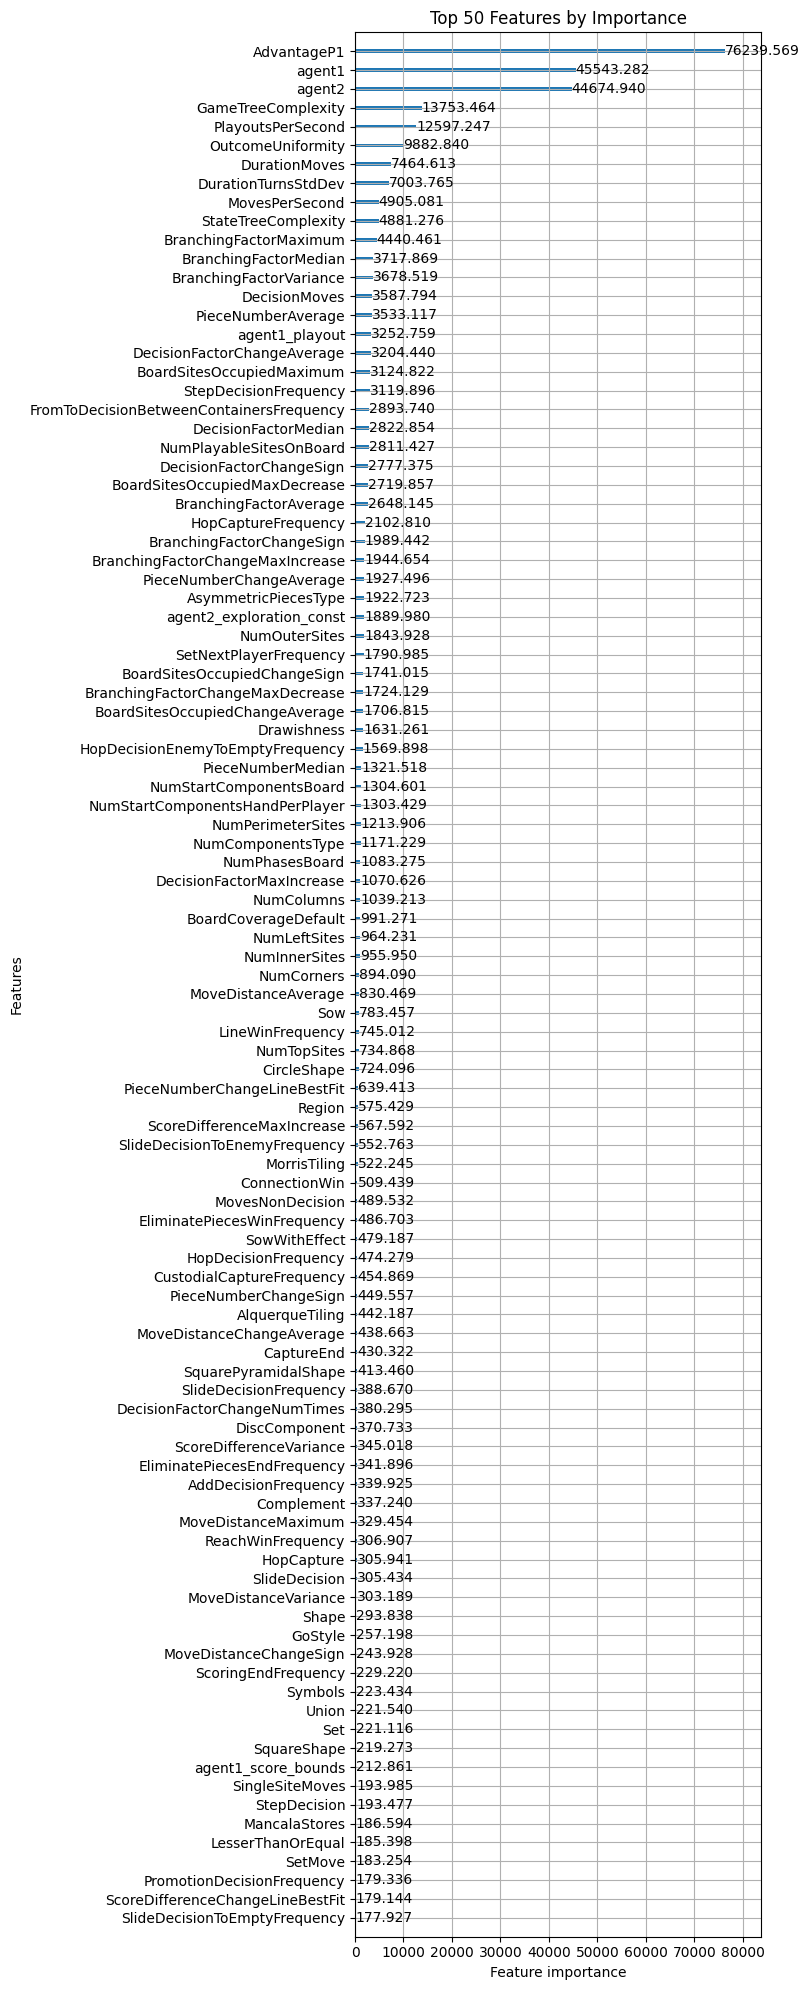

Fold 5 - RMSE: 0.41555459205807543
List of oof scores: [0.4203707711710769, 0.43224830560396205, 0.43923864935783286, 0.4298461167754095, 0.41555459205807543]
Average oof score: 0.42745168699327135


In [6]:
# Define the number of folds for cross-validation
num_folds = 5

# # Shuffle the train dataset
# df_train = df_train.sample(frac=1, random_state=2112).reset_index(drop=True)

# Define the column for stratified or group k-fold
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = gkf.split(df_train, groups=df_train[groups_col])

target = 'utility_agent1'

# Define the parameters
params = {
    'objective': "regression",
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'max_depth': 10,
    'learning_rate': 0.1,
    'reg_alpha': 1e-1,
    'reg_lambda': 1e-1,
    'feature_fraction': 0.8,
    # 'bagging_fraction': 0.9,
    #'bagging_freq': 1,
    'verbose': -1,
    'seed': 2112,
}

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []
feature_importances = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
    y_train, y_val = X_train[target], X_val[target]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(
        data=X_train[numerical_cols + categorical_cols],
        label=y_train,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )
    val_data = lgb.Dataset(
        data=X_val[numerical_cols + categorical_cols],
        label=y_val,
        categorical_feature=categorical_cols,
        free_raw_data=True
    )

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[
            lgb.log_evaluation(period=50),
            # lgb.early_stopping(stopping_rounds=100)
        ]
    )
    lgb.plot_importance(model, figsize=(8, 20), importance_type='gain', max_num_features=100)
    plt.title('Top 50 Features by Importance')
    plt.tight_layout()
    plt.show()
    
    # Save the trained model to the list
    trained_models.append(model)

    # predict on validation set
    y_pred = model.predict(X_val[numerical_cols + categorical_cols])
    y_pred = np.clip(y_pred, -1, 1)
    
    # Compute RMSE on scaled values
    rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_val
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# save oof predictions
oof.to_csv(path_results / 'oof_lightgbm.csv', index=False)


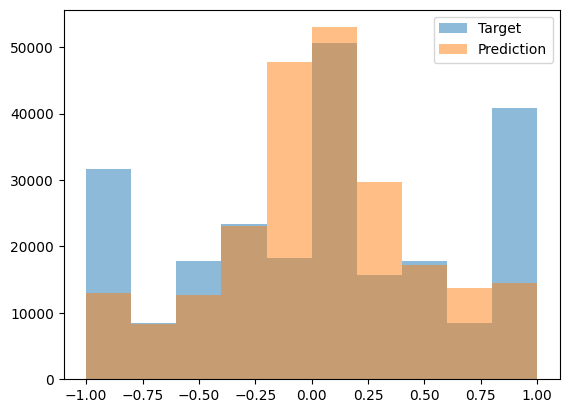

In [7]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [8]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [9]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [10]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

***